### 投資信託で効率的フロンティアを計算してみる

- `2014091602`: AB･米国成長株投信Dコース(H無) 予想分配金
  - https://www.wealthadvisor.co.jp/FundData/SnapShot.do?fnc=2014091602
- `2018103105`:eMAXIS Slim全世界株式(オール･カントリー) 
  - https://www.wealthadvisor.co.jp/FundData/SnapShot.do?fnc=2018103105
- `2015042708`: ニッセイ TOPIXインデックスファンド
  - https://www.wealthadvisor.co.jp/FundData/SnapShot.do?fnc=2015042708
- `2019092601`: SBI・V・S&P500インデックス・ファンド
  - https://www.wealthadvisor.co.jp/FundData/SnapShot.do?fnc=2019092601
- `2018070301`: eMAXIS Slim米国株式(S&P500)
  - https://www.wealthadvisor.co.jp/FundData/SnapShot.do?fnc=2018070301
- `2011020701`: 三菱UFJ 純金ファンド（←保有していないですが金価格の参考として）
  - https://www.wealthadvisor.co.jp/FundData/SnapShot.do?fnc=2011020701


### データの読み込み
[WEALTH ADVISER](https://www.wealthadvisor.co.jp)から手動で取得した週次のcsvデータを使用して、効率的フロンティアを計算してみます。


In [1]:
import os

import pandas as pd

データ保存先ディレクトリ = "C://Users//nanja-win-ms//Dropbox//PC//Downloads//"
投資信託一覧 = {
    "2018103105": "eMAXIS Slim全世界株式(オール･カントリー)",
    "2015042708": "ニッセイ TOPIXインデックスファンド",
    "2019092601": "SBI・V・S&P500インデックス・ファンド",
    "2018070301": "eMAXIS Slim米国株式(S&P500)",
    "2011020701": "三菱UFJ 純金ファンド",
}

投資信託リターン = {}

for 投資信託ID, 投資信託名 in 投資信託一覧.items():
    月次リターンファイル名 = [
        c
        for c in os.listdir(os.path.join(データ保存先ディレクトリ, 投資信託ID))
        if c.startswith("基準価額")
    ][0]
    投資信託リターン[投資信託ID] = pd.read_csv(
        os.path.join(データ保存先ディレクトリ, 投資信託ID, 月次リターンファイル名), encoding="cp932"
    )
    投資信託リターン[投資信託ID].columns = ["日付", 投資信託名]

### データの整形

ｘ＝日付、ｙ＝銘柄名のデータを作成します。投資信託でなく株式でも可能です。

In [2]:
ポートフォリオ = None

for 投資信託ID in 投資信託一覧.keys():
    if ポートフォリオ is None:
        ポートフォリオ = 投資信託リターン[投資信託ID]
    else:
        ポートフォリオ = pd.merge(ポートフォリオ, 投資信託リターン[投資信託ID], on="日付")


ポートフォリオ.index = pd.to_datetime(ポートフォリオ["日付"], format="%Y%m%d")
ポートフォリオ.drop("日付", axis=1, inplace=True)

ポートフォリオ

,eMAXIS Slim全世界株式(オール･カントリー),ニッセイ TOPIXインデックスファンド,SBI・V・S&P500インデックス・ファンド,eMAXIS Slim米国株式(S&P500),三菱UFJ 純金ファンド
日付,,,,,
2020-01-10,11828,11720,11203,12185,13827
2020-01-17,12036,11723,11429,12428,14063
2020-01-24,11932,11689,11381,12378,14008
2020-01-31,11667,11379,11189,12168,14085
2020-02-07,11987,11703,11490,12496,14242
...,...,...,...,...,...
2023-12-29,20899,17484,22229,24281,23054
2024-01-05,20972,17684,22285,24342,23270
2024-01-12,21283,18428,22763,24871,23226


### 可視化

<Axes: xlabel='日付'>

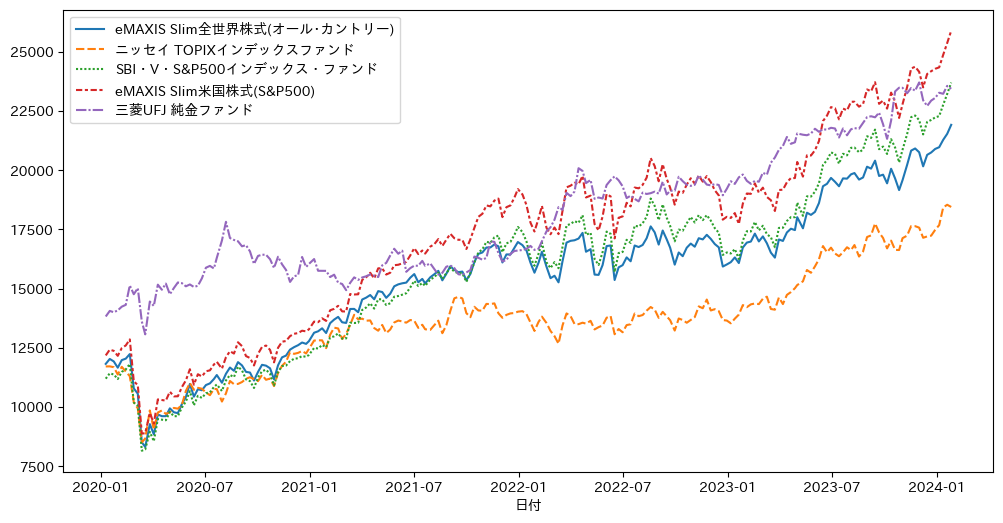

In [3]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=ポートフォリオ)

In [4]:
from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientFrontier

mu = expected_returns.mean_historical_return(ポートフォリオ)
S = risk_models.sample_cov(ポートフォリオ)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 115.5%
Annual volatility: 34.2%
Sharpe Ratio: 3.32


(1.1546507705298557, 0.34188826020611157, 3.318776637272708)

Expected annual return: 115.1%
Annual volatility: 34.1%
Sharpe Ratio: 3.32


<Axes: xlabel='Volatility', ylabel='Return'>

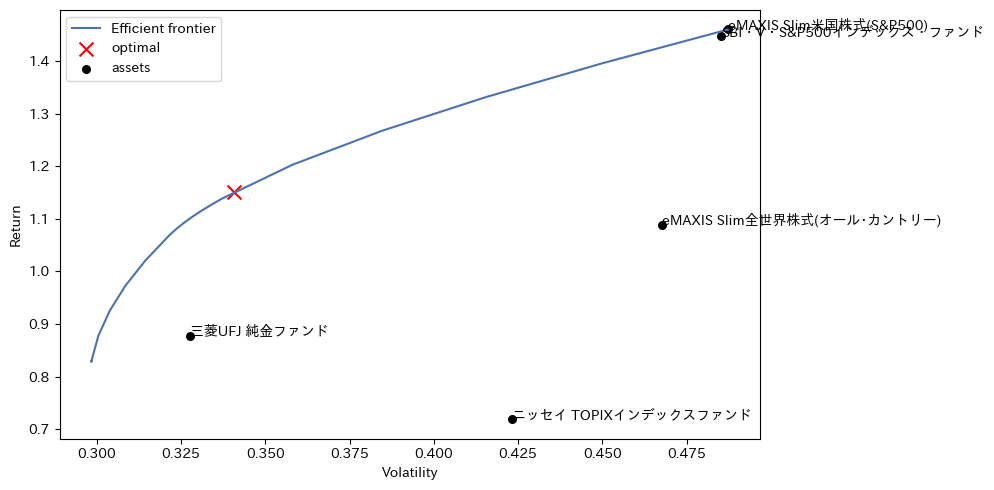

In [5]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)

plt.figure(figsize=(10, 5))
plotting.plot_efficient_frontier(cla, show_assets=True, points=50, show_tickers=True)

### 値動きの相関
値動きの変化で相関を計算してみます。

<Axes: >

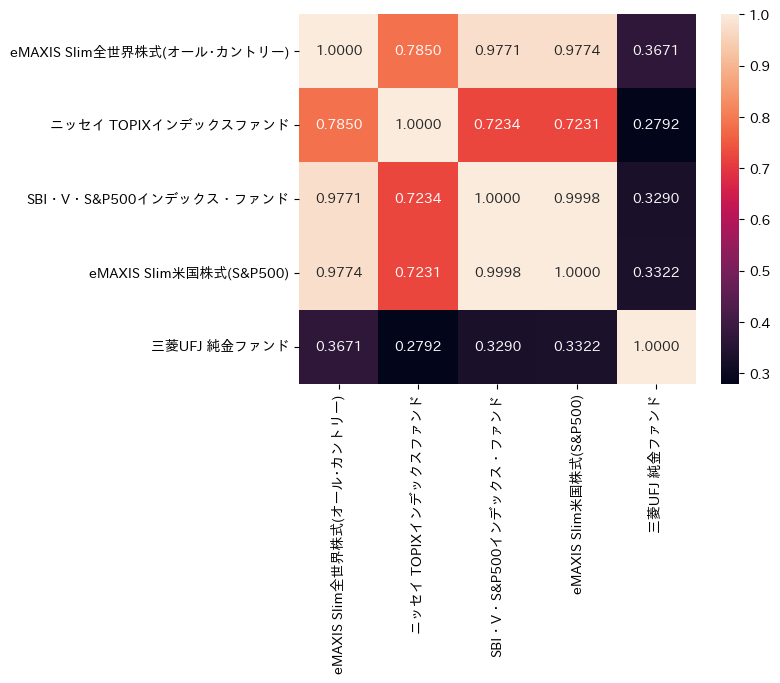

In [6]:
sns.heatmap(ポートフォリオ.diff().dropna().corr(), annot=True, fmt="1.4f")